# Math 377 Fall 2018

#### Name:
#### Section:

**Documentation Statement:**

# Project: Predicting Spam
### Data Collection, Summarization, Inference and Prediction

<img style="float: right;" src="img\spam3.jpg">
This project is designed to cover many of the main ideas of the entire course. We will go into a little more detail with the data collection and prediction. Ultimately we want to predict if an email is spam. In the course of doing this, we will collect data, clean it up, work with string data, make a simple inference, and then build a naive bayes model from the ground up. We will then bring in the package `scikit-learn` to check our work and add extra functionality.



By the end of project, you should know how to:

1. Find and import data.
2. Use regular expressions to edit string data.
3. Determine if a word helps to identify an email as spam or not.
4. Create a function to predict the type of email using the ideas of Bayesian Classification.
5. Assess your model and propose improvements.

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect by displaying it. You can add additional names or functions to the provided cells in order to organize your work. 

**Authorized Resources:** Anyone and anything.

### 1. Background Information 

There are a couple of reference papers that may be of interest to explore. The first is "Better Bayesian Filtering" by Paul Graham,http://bit.ly/1ycPbiy. The second is "A Plan for Spam" also by Paul Graham, http://bit.ly/1ycPcmA

### 2. Load Packages  

To get started, load `datascience`, `numpy`, `plots`, and `pandas`.

In [1]:
import datascience as ds #note the labs use from datascience import * but this is not a good practice
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### 3. Get Data

We are going to use data from the [Apache SpamAssasian](https://spamassassin.apache.org/) website. In particular we want data from their public corpus, see the readme document at https://spamassassin.apache.org/old/publiccorpus/.

We have provided you the data in a zip file, spam.zip, because the data on the website is in a `tar` and `bz2` zip format. There are functions in python that allow you to address these types of file, see https://docs.python.org/3/library/tarfile.html, but it is not worth the extra coding effort at this point.

You should extract the zip file and place the three folders in a folder called data under the directory where you are running this notebook. The three folders are  
easy_ham  
spam  
hard_ham  

The files names are the message number and the MD5 checksum. This is not convenient nomenclature. To access the files we will use the `glob` package, https://docs.python.org/3/library/glob.html. We also use the `os` package to get the current working directory on your machine. Below is the code to open one file to view its contents. 

Note: using the `with` argument will automatically close the file upon completion of the loop.

In [2]:
import glob,re,os

In [3]:
# Get working directory
cwd = os.getcwd()
path=cwd +'\\data\\*\\*'
path

'C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\*\\*'

In [4]:
glob.glob(path)[:5] #Returns list with all the files in it, we will look at first 5.

['C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\easy_ham\\0001.ea7e79d3153e7469e7a9c3e0af6a357e',
 'C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\easy_ham\\0002.b3120c4bcbf3101e661161ee7efcb8bf',
 'C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\easy_ham\\0003.acfc5ad94bbd27118a0d8685d18c89dd',
 'C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\easy_ham\\0004.e8d5727378ddde5c3be181df593f1712',
 'C:\\Users\\Brad.Warner\\Documents\\Classes\\Math 377\\Fall 2018\\data\\easy_ham\\0005.8c3b9e9c0f3f183ddaf7592a11b99957']

Let's read in the first file and print out the contents. You can scroll down and read the email to get a feel for the content.

In [5]:
with open(glob.glob(path)[0],'r') as file: #the 'r' tells python to read the file only.
    for line in file:
        print(line)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002

Return-Path: <exmh-workers-admin@example.com>

Delivered-To: zzzz@localhost.netnoteinc.com

Received: from localhost (localhost [127.0.0.1])

	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36

	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)

Received: from phobos [127.0.0.1]

	by localhost with IMAP (fetchmail-5.9.0)

	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)

Received: from listman.example.com (listman.example.com [66.187.233.211]) by

    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for

    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100

Received: from listman.example.com (localhost.localdomain [127.0.0.1]) by

    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002

    07:35:02 -0400 (EDT)

Delivered-To: exmh-workers@listman.example.com

Received: from int-mx1.corp.example.com (int-mx1.corp.example.com

    [172.1

There is a tremendous amount of information in each email. To keep this project in scope, let's just use the subject line as our predictor. We need to use string commands from the `re` package to extract the subject line from each file. We will create a list of the subject line, the predictor, and the class of the email, spam or not. We determine class from the folder name. 

The command `re.sub` requires a regular expression. We will use `^Subject` as this tells the function we want to find  at the start of the string, https://docs.python.org/2/library/re.html. The method `strip` takes out the white spaces at the beginning and end of the string.

To read in the files we will use `latin1` codec because the default and standard `utf-8` produce an error. We could ignore the error as well. To see more information on this go to http://balusc.omnifaces.org/2009/05/unicode-how-to-get-characters-right.html

In [6]:
file_read = 0
subject_line=0
data=[]
for fn in glob.glob(path):
    is_spam = "ham" not in fn
    file_read +=1
    with open(fn,'r',encoding = 'latin1') as file:
        # could use errors='ignore' instead of encoding
        #print("In ",fn) #if we want to troubleshoot
        for line in file:
            if line.startswith("Subject:"):
                subject_line +=1
                #print("Subject line: ",subject_line) #if we want to trouble shoot
                subject=re.sub(r"^Subject: ","",line).strip()
                data.append((subject,is_spam))
                break # don't read any more lines some files have more than one subject line
print(file_read," Files read")
print(subject_line, "Subject lines read")

3302  Files read
3300 Subject lines read


We had to make sure not to read a second subject line, for instance in the orginal email was copied on the reply. We also had two files that did not contain a subject line. We could investigate this but we will just use the 3300 files that we read.

Printing out the first 10 elements of the data list gives an idea of the emails' subject lines.

In [7]:
data[:10]

[('Re: New Sequences Window', False),
 ('[zzzzteana] RE: Alexander', False),
 ('[zzzzteana] Moscow bomber', False),
 ("[IRR] Klez: The Virus That  Won't Die", False),
 ('Re: Insert signature', False),
 ('Re: [zzzzteana] Nothing like mama used to make', False),
 ('Re: [zzzzteana] Nothing like mama used to make', False),
 ('[zzzzteana] Playboy wants to go out with a bang', False),
 ('Re: [zzzzteana] Nothing like mama used to make', False),
 ('[zzzzteana] Meaningful sentences', False)]

We are not sure what zzzzteana means and whether it is only associated with ham. This may be something we remove later.

In [8]:
len(data) # Number of emails with subject lines

3300

In [9]:
sum(list(zip(*data))[1]) #Number of spam emails

500

In [10]:
# Proportion of spam emails in data
print("Percentage of spam emails in data: "+"{:.2%}".format(500/(500+3300)))

Percentage of spam emails in data: 13.16%


### 4. Feature Engineering  

We are dealing with string data as our predictor. We first need to clean it up. The choices we make here will potentially have a big impact on the quality of the model. Ideally we would go back and test the sensitivity of our results to these choices.

First we will make all the text lower case. This will ensure that words such as Free and free are viewed as equivalent. This may not be a good idea for spam detection as a word in all capital letters might be more indicative of spam.  

We will be dealing with frequencies in this project but we could also try other ideas such as vector encoding and n-grams.

#### Clean Data

We will first get the subject lines in a standard format with lower cases, no punctuation, and the removal of stopwords.

In [11]:
# Example of the function we need.
'FREE'.lower()

'free'

Next, we need to tokenize our string. This means to split the string into a list of words. This requires the use of regular expressions, https://docs.python.org/2/library/re.html. 

As an example, we will use the first ten subject lines of the data object.

In [12]:
for subject, is_spam in data[:10]:
    print(re.findall("[a-z0-9']+",subject.lower()))

['re', 'new', 'sequences', 'window']
['zzzzteana', 're', 'alexander']
['zzzzteana', 'moscow', 'bomber']
['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
['re', 'insert', 'signature']
['re', 'zzzzteana', 'nothing', 'like', 'mama', 'used', 'to', 'make']
['re', 'zzzzteana', 'nothing', 'like', 'mama', 'used', 'to', 'make']
['zzzzteana', 'playboy', 'wants', 'to', 'go', 'out', 'with', 'a', 'bang']
['re', 'zzzzteana', 'nothing', 'like', 'mama', 'used', 'to', 'make']
['zzzzteana', 'meaningful', 'sentences']


Finally, it is a common step in text preparation to remove common words, called stop words, for example the word the. These words are common and tend not to aid in prediction. 

An easy source for these words comes from the `nltk`, natural language toolkit, package.

In [13]:
import nltk
# Getting the English stop words from nltk
stop_words = nltk.corpus.stopwords.words('english')

# Printing out the first eight stop words
print(stop_words[:8])

#We will convert our stopwords to a set as set lookup is much faster

stop_words = set(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves']


We will now remove the the stopwords and test some code to see the changes in the subject lines. We will do this for the first 5 subject lines.

In [14]:
for subject, is_spam in data[:5]:
    final_words = []
    print("Original subject line: ",subject)
    print("Split line: ",re.findall("[a-z0-9']+",subject.lower()))
    words = re.findall("[a-z0-9']+",subject.lower())
    [final_words.append(word) for word in words if word not in stop_words]
    print("Clean line: ",final_words)

Original subject line:  Re: New Sequences Window
Split line:  ['re', 'new', 'sequences', 'window']
Clean line:  ['new', 'sequences', 'window']
Original subject line:  [zzzzteana] RE: Alexander
Split line:  ['zzzzteana', 're', 'alexander']
Clean line:  ['zzzzteana', 'alexander']
Original subject line:  [zzzzteana] Moscow bomber
Split line:  ['zzzzteana', 'moscow', 'bomber']
Clean line:  ['zzzzteana', 'moscow', 'bomber']
Original subject line:  [IRR] Klez: The Virus That  Won't Die
Split line:  ['irr', 'klez', 'the', 'virus', 'that', "won't", 'die']
Clean line:  ['irr', 'klez', 'virus', 'die']
Original subject line:  Re: Insert signature
Split line:  ['re', 'insert', 'signature']
Clean line:  ['insert', 'signature']


#### Subject Line Frequency  

Before going further with inference or prediction, let's summarize the data. We want to count the total number of times a word occurrs in a subject line separately in both the spam and ham data sets. We need to count the word once per subject line.

First, let's write a function that will tokenize our data, remove stop words, and remove duplicates.

In [15]:
def token(subject,sw):
    words = re.findall("[a-z0-9']+",subject.lower())
    return set([word for word in words if word not in sw])

In [16]:
# Test the function
print(token(data[3][0],stop_words))

{'irr', 'virus', 'klez', 'die'}


Let's count the words seperately in the spam and ham data and look for patterns. Our tokenize function returns a list so that when we iterate over all the subject lines we will return a list of lists. As a final step, we need to flatten the list. We will experiment with some code first.

In [17]:
# Illustrate the code using the first 3 subject lines
#Get the subject lines for spam
spam_subjects = [i for i,v in data if v]
#Tokenize and then append
spam_words=[]
for subject in spam_subjects[:3]:
    spam_words.append(token(subject,stop_words))
print("List after using token: ",spam_words,"\n")
#Create one long list of words
spam_words = [item for sublist in spam_words for item in sublist]
print("The flattened list: ",spam_words)

List after using token:  [{'life', 'insurance', 'pay'}, {'10', '30', '12', 'guaranteed', 'lose', 'ilug', 'days', 'lbs', '206'}, {'10', '30', '12', '150', 'guaranteed', 'lose', 'days', 'lbs', '11'}] 

The flattened list:  ['life', 'insurance', 'pay', '10', '30', '12', 'guaranteed', 'lose', 'ilug', 'days', 'lbs', '206', '10', '30', '12', '150', 'guaranteed', 'lose', 'days', 'lbs', '11']


In [18]:
#Run for all the spam emails
#Get the subject lines for spam
spam_subjects = [i for i,v in data if v]
#Tokenize and then append
spam_words=[]
for subject in spam_subjects:
    spam_words.append(token(subject,stop_words))
spam_words = [item for sublist in spam_words for item in sublist]

In [19]:
#This code counts the words using a dictionary structure
spam_word_count={}
for word in spam_words:
    if word in spam_word_count:
        spam_word_count[word] +=1
    else:
        spam_word_count[word]=1

As a test, we can use get the counts, values, for a word, key.

In [20]:
spam_word_count['free']

32

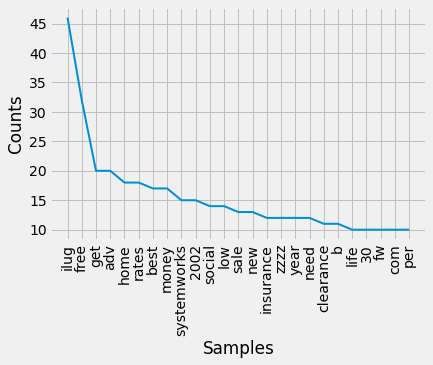

In [21]:
# We could also do this with the nltk package Let's not put this in the project!
# Creating the word frequency distribution
freqdist = nltk.FreqDist(spam_words)

# Plotting the word frequency distribution
freqdist.plot(25)

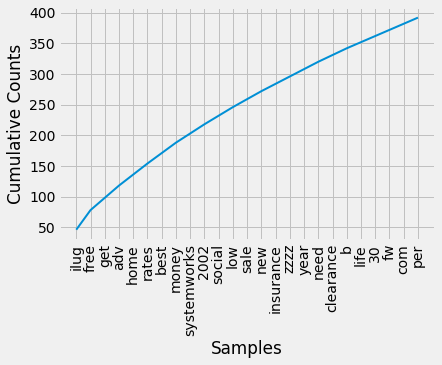

In [22]:
freqdist.plot(25,cumulative=True)

In [23]:
# The total number of spam words
freqdist.N()

2408

Let's do the same thing with the table function from the `datascience` package.

In [24]:
# Using the datascience package to get counts and frequency
spam_table = ds.Table().with_columns("Words",spam_words)
spam_word_counts = spam_table.group('Words').sort('count',descending=True).relabel('count','Spam Count')
spam_word_counts.show(5)

Words,Spam Count
ilug,46
free,32
get,20
adv,20
rates,18


Next we want to create a column that has the subject line frequency of each word. This is the percentage of subject lines in the spam emails that contain the word of interest. We also sort the table from most frequent to least frequent.

In [25]:
spam_word_counts = spam_word_counts.with_column('Spam Subject Line Frequency',spam_word_counts.column('Spam Count')/500).\
set_format("Spam Subject Line Frequency", ds.NumberFormatter(decimals=4))
spam_word_counts

Words,Spam Count,Spam Subject Line Frequency
ilug,46,0.0920
free,32,0.0640
get,20,0.0400
adv,20,0.0400
rates,18,0.0360
home,18,0.0360
money,17,0.0340
best,17,0.0340
systemworks,15,0.0300
2002,15,0.0300


To summarize, 9.2% of the subject lines in the spam emails contain the word ilug. As a reminder, the vocabulary of words in the spam subject line consists of 2408 words where 1135 are unique words.

In [26]:
spam_word_counts.num_rows

1135

In [27]:
sum(spam_word_counts.column('Spam Count'))

2408

In [28]:
spam_word_counts.where('Spam Count',1)

Words,Spam Count,Spam Subject Line Frequency
zzzzason,1,0.0020
zzzz8969,1,0.0020
zbm,1,0.0020
ytu855,1,0.0020
yr,1,0.0020
youth,1,0.0020
younger,1,0.0020
york,1,0.0020
yeni,1,0.0020
ya,1,0.0020


To visualize the results, we will use a bar chart.

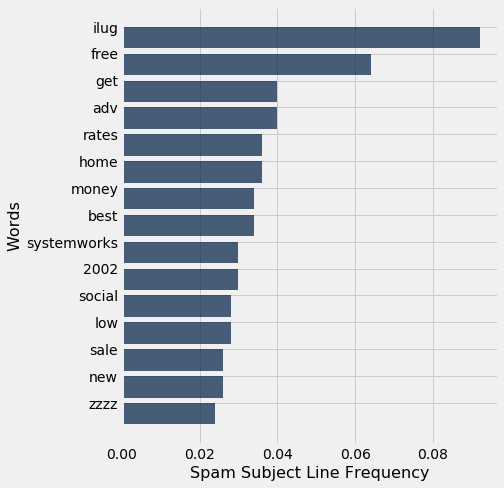

In [29]:
spam_word_counts.take(np.arange(15)).barh('Words',select="Spam Subject Line Frequency")

Next we will repeat for ham.

In [30]:
#Repeat for ham
ham_subjects = [i for i,v in data if not v]
#Tokenize and then append
ham_words=[]
for subject in ham_subjects:
    ham_words.append(token(subject,stop_words))
ham_words = [item for sublist in ham_words for item in sublist]
ham_words[:6]

['sequences', 'window', 'new', 'alexander', 'zzzzteana', 'bomber']

In [31]:
# Creating a datatable
ham_table = ds.Table().with_columns("Words",ham_words)
ham_word_counts = ham_table.group('Words').sort('count',descending=True).relabel('count','Ham Count')
ham_word_counts

Words,Ham Count
satalk,141
spambayes,135
new,117
users,108
2,108
ilug,94
use,91
razor,91
2002,89
zzzzteana,87


In [32]:
ham_word_counts = ham_word_counts.with_column('Ham Subject Line Frequency',ham_word_counts.column('Ham Count')/(3300-500)).\
set_format("Ham Subject Line Frequency", ds.NumberFormatter(decimals=4))
ham_word_counts

Words,Ham Count,Ham Subject Line Frequency
satalk,141,0.0504
spambayes,135,0.0482
new,117,0.0418
users,108,0.0386
2,108,0.0386
ilug,94,0.0336
use,91,0.0325
razor,91,0.0325
2002,89,0.0318
zzzzteana,87,0.0311


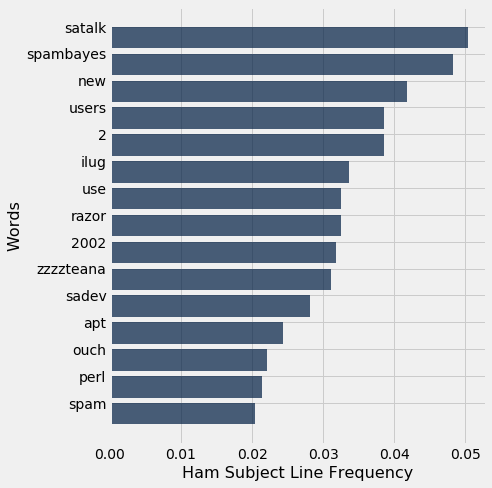

In [33]:
ham_word_counts.take(np.arange(15)).barh('Words',select="Ham Subject Line Frequency")

In [34]:
sum(ham_word_counts.column('Ham Count'))

12163

In [35]:
ham_word_counts.num_rows #Number of unique words in ham subject lines

3727

There are 12163 words in the ham email subject lines of which 3727 are unique. We will have many words that only appear once.

In [36]:
ham_word_counts.where('Ham Count',1)

Words,Ham Count,Ham Subject Line Frequency
zoo,1,0.0004
zone,1,0.0004
zombies,1,0.0004
zen,1,0.0004
zealots,1,0.0004
yup,1,0.0004
youth,1,0.0004
youngest,1,0.0004
yoga,1,0.0004
yet,1,0.0004


As a reminder, in the spam subject line there are 1135 unique words while there are 3727 in the ham. When we merge these data sets there will only be partial overlap.

In [37]:
spam_word_counts.num_rows #Number of unique words in spam subject lines

1135

In [38]:
ham_word_counts.num_rows #Number of unique words in ham subject lines

3727

There are many more words in the ham subject lines than in the spam subject lines. We need to get one table with the words and counts. This will increase the number of rows for the spam. The built-in join function from the `datascience` package only performs an inner joining. We need to perform an outer join. We cannot determine how to do this with the join function from `datascience` so let's convert the table to pandas dataframes and then perform an outer join, see https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/. By default, pandas repalces missing values with NaN, not a number. We must replace those missing values with 0. Finally, we can convert back to a datascience table.

In [39]:
# Convert data.science table to pandas dataframe
word_counts = pd.merge(ham_word_counts.to_df(),spam_word_counts.to_df(),how="outer").fillna(0)
word_counts = ds.Table.from_df(word_counts)
word_counts

Words,Ham Count,Ham Subject Line Frequency,Spam Count,Spam Subject Line Frequency
satalk,141,0.0503571,1,0.002
spambayes,135,0.0482143,0,0
new,117,0.0417857,13,0.026
users,108,0.0385714,0,0
2,108,0.0385714,3,0.006
ilug,94,0.0335714,46,0.092
use,91,0.0325,2,0.004
razor,91,0.0325,0,0
2002,89,0.0317857,15,0.03
zzzzteana,87,0.0310714,0,0


Let's visualize the results by looking at the most common words in the ham subject lines.

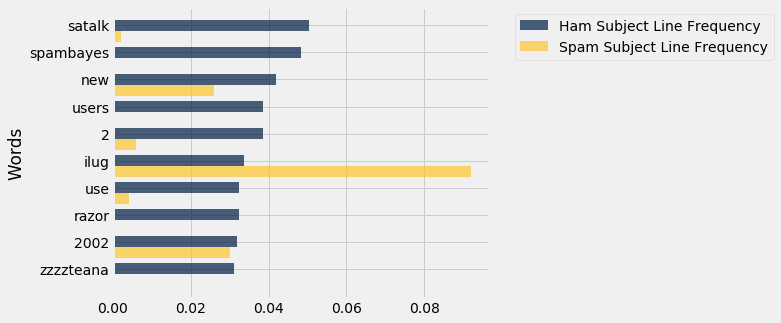

In [40]:
word_counts.take(np.arange(10)).select('Words','Ham Subject Line Frequency','Spam Subject Line Frequency').barh('Words')

Now, the same visualization but with the most common words in the spam emails. Notice that we switch colors of spam and ham in this second plot.

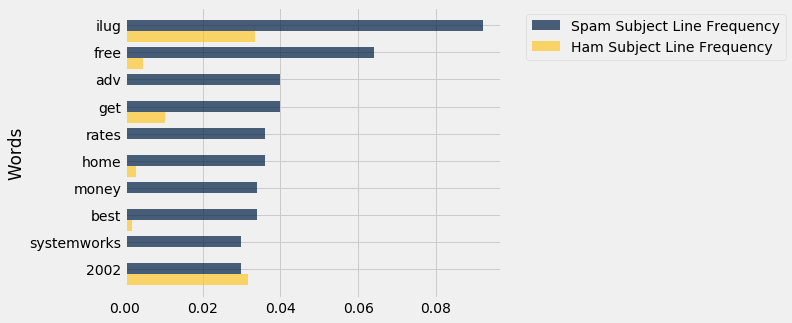

In [41]:
word_counts.sort('Spam Subject Line Frequency',descending=True).\
take(np.arange(10)).select('Words','Spam Subject Line Frequency','Ham Subject Line Frequency').barh('Words')

### 5. Inference

From personal experience of recieving many spam emails over the years, we beleive that the word free appears in spam emails much more often than in regular, ham, emails. Let's test this hypothesis using our data.

First let's get the data. Nore: We already have a the data in the above plot.

In [42]:
word_counts.where('Words','free')

Words,Ham Count,Ham Subject Line Frequency,Spam Count,Spam Subject Line Frequency
free,13,0.00464286,32,0.064


From the intitial section of this analysis, we found that there were 3300 emails of which 500 are spam. Thus 2800 are ham. Let's put this data in a table.


In [43]:
free = ds.Table().with_columns('Word', ds.make_array("Free", "No Free", "Free", "No Free")
                               , 'Type', ds.make_array("Spam","Spam","Ham","Ham"), 
                               'Count',  ds.make_array(32, (500 - 32) , 13, (2800 - 13)))
free

Word,Type,Count
Free,Spam,32
No Free,Spam,468
Free,Ham,13
No Free,Ham,2787


Our hypothesis before collecting and summarizing the data was that the word free would appears in spam emails more frequently than in ham emails. Now we have data that supports this as 6.4% of spam emails contain the word while on ly 0.46% of ham emails contain it. 

This difference could be due to random chance. Let's perform a hypothesis test to determine the probability of our observed data.

We now construct the framework for our hypothesis test.

> **Null Hypothesis**: Spam emails are equally likely to contain the word "free" as ham emails.

Under the null hypothesis we assume that the word free does not appear more likely in either ham or spam. Remember that ham is much more common than spam, so we need to be careful about our randomization process. 

Prior to collecting data, we suspected that free would appear more often in spam emails. The alternative hypothesis is:

> **Alternative Hypothesis**: Spam emails are more likely to contain the word "free" as compated with ham emails.

*Technical note*: The word frequencies are not random samples from any population of emails so we must be careful about generalizing our results.  For example, most people have not recieved an email with the word 'ilug' in it. 

*Important requirements for our test statistic:* We want to choose a test statistic for which large positive values are evidence in favor of the alternative hypothesis, and other values are evidence in favor of the null hypothesis. This is because once we've determined the direction of our alternative hypothesis, we only care about the tail in that direction. If, for example, our p-value cutoff was 5%, we'd check to see if our observed test statistic fell within the largest 5% of values in our null hypothesis distribution. 

Our test statistic should depend only on whether free is more common in spam than ham. Thus we choose:

> **Test Statistic**: The number of times free appears in the subject line of 500 spam emails minus the number of times free appears in the subject line of 2800 ham emails.

We need to create a data table to sample from. First we need a list of whether the subject contains free or not and then the email type.

In [44]:
word_list=["Free"]*32
word_list.extend(["Not Free"]*468)
word_list.extend(["Free"]*13)
word_list.extend(["Not Free"]*2787)
email=["Spam"]*500
email.extend(["Ham"]*2800)

In [45]:
inf_tab = ds.Table().with_columns("Email",email,"Word",word_list)
inf_tab

Email,Word
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free
Spam,Free


Now the summary of the data.

In [46]:
inf_tab.pivot("Word","Email")

Email,Free,Not Free
Ham,13,2787
Spam,32,468


Next we need to calculate our test statistic.

In [47]:
int(np.diff(inf_tab.pivot("Word","Email").column('Free')))

19

The randomization process must be done carefully. We don't want to take an email and randomly assign the word free as in a coin flip. Instead, if the word free is really independent of the email type then would could shuffle the assignment of the word with the email type. This is how we will do our randomization. 

First let's experiment with some code.

In [48]:
temp=[1,1,1,2,2]
temp2=np.random.permutation(temp)
temp,temp2

([1, 1, 1, 2, 2], array([1, 1, 2, 1, 2]))

Now our randomization scheme.

In [49]:
ds.Table().with_columns("Email",email,"Word",np.random.permutation(inf_tab.column('Word'))).pivot("Word","Email")

Email,Free,Not Free
Ham,40,2760
Spam,5,495


In [50]:
int(np.diff(ds.Table().with_columns("Email",inf_tab.column('Email'),"Word",np.random.permutation(inf_tab.column('Word')))\
        .pivot("Word","Email").column('Free')))

-31

Let's create a function to implement our randomization and return of the test statistic.

In [51]:
def test_stat_simulation(data_tab):
    temp = np.diff(ds.Table().with_columns("Email",data_tab.column('Email'),"Word",np.\
        random.permutation(data_tab.column('Word')))\
        .pivot("Word","Email").column('Free'))
    return int(temp)

In [52]:
test_stat_simulation(inf_tab)

-25

Let's repeat the process and see what conclusion we reach.

In [53]:
def simulate_under_null(num_shuffles,data_tab):
    """Simulates randomly shuffling the names of ham ans spam where the word free occurrs
    
    num_shuffles is the number of times to simulate the shuffling.
    data_tab is the Table with the data
    """
    test_stat = ds.make_array()
    for i in np.arange(num_shuffles):
        test_stat = np.append(test_stat,test_stat_simulation(data_tab))
    return test_stat

In [62]:
simulated_results = ds.Table().with_column('Test statistic under null', simulate_under_null(1000,inf_tab))
simulated_results

Test statistic under null
-37
-33
-35
-33
-29
-31
-31
-25
-31
-27


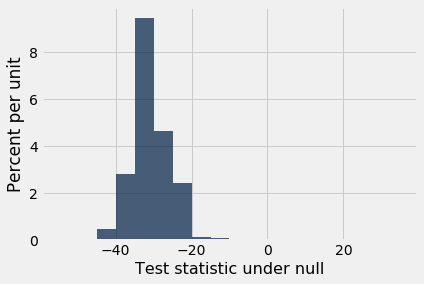

In [63]:
simulated_results.hist(0, bins=np.arange(-55, 40, 5))

If the null hypothesis were true, then we did not witness a single simulation with a result where the test statistic was positive let alone as high as our observed value of 19. The probability of our observed result is negilible, thus leading us to conclude that the word free appears in spam emails much pften than is expected by chance.  

We have to be careful about the assumptions of this test and generalizing the results to a larger population.

This test assumes the percentage of spam emails is 13.16% and that the word free appears in a subject line about 1.3% of the time. We did not alter these percentages in the simulation.

We also assumed the emails are representative of only those emails in the collections. Generalization to a larger population must be cautioned.

### 6. Simple Prediction Model

We will use the word free to make a simple classifier. Our model is this: if the subject line contains the word free, we will classify it as spam, if not then as ham. Since there is no learning, this is not a machine learning algorithmn. 

We will use the algorithm on all our data and measure the performance. This will help us explore metrics of performance.

The pivot table we derived above gives us all the data we need to explore this simple model.

In [54]:
inf_tab.pivot("Word","Email")

Email,Free,Not Free
Ham,13,2787
Spam,32,468


The predicted outcome is to predict spam if the subject line contains the the word free. Thus the column called Free could be called Predict Free and the column Not Free would be Predict Ham. If we, arbitarily, call the case of a spam email having the word free as a positive result, then we have 32 true positives. We have 2787 true negatives, 13 false positive, and 468 false negatives. 

One measure of performance is accuracy, how many predictions were correct out of the total. Accuracy is

$$
{(TP + FN) \over (TP + TN + FP + FN)}
$$

In [55]:
print("Accuracy is: {:.2%}".format((32+2787)/(13+32+2787+468)))

Accuracy is: 85.42%


This seems impressive, our model was 85.4% accurate.  Remember most of the emails are ham. We could just classify all emails as ham. This leads to an accuracy almost as impressive.

In [56]:
print("Accuracy for calling everything ham is: {:.2%}".format((13+2787)/(13+32+2787+468)))

Accuracy for calling everything ham is: 84.85%


Other metrics are the recall and precision. 

Recall is the percentage of all true spam emails that we correctly classified.
$$
{TP \over (TP + FN)}
$$
and precision is the precentage of all predicted spam emails that we correctly classified.

$$
{TP \over (TP + FP)}
$$

In [57]:
print("Precision is: {:.2%}".format((32)/(32+468)))
print("Recall is: {:.2%}".format((32)/(32+13)))

Precision is: 6.40%
Recall is: 71.11%


Of the emails that were spam, we only indentified 6.4% of them with our model. 

Of all the emails we called spam, 71.11% were spam. 

These metrics gives a much different impression of the classifier.

We can combine these as a geometric mean to get a single number, this is called the $F_{1}$ score and is
$$
F_{1}={1 \over {1 \over Precision} + {1 \over Recall}}
$$

In [58]:
precision = (32)/(32+468)
recall = (32)/(32+13)
print("F1 score is: {:.2%}".format(1/(1/precision+1/recall)))

F1 score is: 5.87%


This is not a good classifier because we are missing so many of the spam emails.

As preparation for our naive Bayes classifier, let's look at our results from a probability perspective.

Let's use the table to make some probability calculations. We can estimate probabilities from this table. We have
$$ P({\rm Free}~| ~{\rm Spam}) = {P({\rm Free} \cap {\rm Spam}) \over P({\rm Spam})} = {32 \over 500}$$  

$$ P({\rm Free}~| ~{\rm Ham}) = {P({\rm Free} \cap {\rm Ham}) \over P({\rm Ham})} = {13 \over 2800}$$  

$$ P({\rm Spam}) = {500 \over 3300}$$  

$$ P({\rm Ham}) = {2800 \over 3300}$$  

We could have looked these next ones up but we will use Bayes Theorem.  

$$ P({\rm Spam}~| ~{\rm Free}) = {P({\rm Free} \cap {\rm Spam}) \over P({\rm Free})} = {P({\rm Free}~| ~{\rm Spam})P({\rm Spam}) \over P({\rm Free})} = {32 \over 45}$$
where
$$P({\rm Free})= P({\rm Free}~| ~{\rm Spam})P({\rm Spam}) + P({\rm Free}~| ~{\rm Spam})P({\rm Spam})$$

In [59]:
# Test the ideas
fgs=32/500
fgh=13/2800
s=500/3300
h=2800/3300

In [60]:
print("The probability of an email being spam given it contains the word free is: {:.2%}".format(fgs*s/(fgs*s+fgh*h)))

The probability of an email being spam given it contains the word free is: 71.11%


To make the model more sophisticated, we could add a second word such as get. The issue here is the we will have to estimate
$$P({\rm Free} \cap {\rm Get}~ | ~{\rm Spam})$$  

$$P({\rm Free} \cap {\rm Not}~{\rm Get} ~| ~{\rm Spam})$$  

$$P({\rm Not}~{\rm Free} \cap {\rm Get} ~ | ~{\rm Spam})$$  

$$P({\rm Not}~{\rm Free} \cap {\rm Not}~{\rm Get} ~ | ~{\rm Spam})$$  

and likewise for ham. This starts to get difficult quickly. 

A simplifying assumption is needed to reduce the computational difficulty.

### 7. Naive Bayes Classification

Naive Bayes models are based on an extreme assumption of conditional independence. They are fast and easy to implement. They work well with high dimensional data. They work reasonably well in text applications and thus are why we are exploring them. There are really no tuning parameters so learning is easy. They make a great starting point for a baseline and sometimes are used as the final model.

This section will implement a naive Bayes model for our spam classification problem.

### Bayesian Classification

This section is based on notes from http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb

Naive Bayes is a Bayesian classification method; these methods use Bayes theorem. We explored this at the end of Section 6.

In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as $P(L~|~{\rm features})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

When we write $P({\rm features})$ we mean a joint probability, for example $P({\rm Free} \cap {\rm Get})$.

It is only the numerator that matters as the denominator will be the same in all calculations for the different labels.

For example, suppose we are trying to decide between two labels—let's call them $L_1$ and $L_2$—then one way to make this decision is to compute the ratio of the posterior probabilities for each label:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

Notice that the denominator does not matter. If the ratio is great than one, then $P(L_1~|~{\rm features})$ is larger and you would select $L_{1}$ as the predicted outcome. You don't need to find the ratio, you simply need to find the maximum of $P({\rm features}~|~L_i)$ for each label.

Next we need an algorithm to compute $P({\rm features}~|~L_i)$ for each label. We could do a lookup table as we did in section 6 but once we start adding many features this becomes too computationally expensive. The different assumptions about this calculation leads to the different types of Bayesian classifiers. In the naive Bayes, we make the assumption of conditional independence. This means within each label, for example a spam email, each word is independent of the others. This is clearly not going to be the case. 

To implement a naive Bayes classifier, we must only calculated the within label univariate density, for continuous features, or probability, for discrete. The joint distribution is found by multiply these univariate distributions. Once the univariate distributions have been estimated, the posterior calcuaton is fast. For discrete text data, we only need to estimate the frequency of each word in each label. Then for multiple words we calculate the joint probability as the product of these individual probabilities. For example
$$P({\rm Free} \cap {\rm Get}~ | ~{\rm Spam}) = P({\rm Free}~ | ~{\rm Spam})P({\rm Get}~ | ~{\rm Spam})$$  

There are still some logistical issues to resolve. first, what is a word does not appear in a subject line? This would lead to a zero estiamted probability and thus the joint probability would be zero as well. A solution to this problem is to use a psuedocount. This is determined as follows:

$$P({\rm Word}~ |~ {\rm Spam}) = {\mbox{Number of times Word apperas in Subject line} + k \over \mbox{Number of Subject lines} +2k}$$  

where $k$ does not need to be an integer.

Second, when we estimate these probabilities, they tend to be small. If the subject has many words, then the product will be extrememly small. We can handle this by working with logarithms.

Finally, we need to get our training and test data. We will attack this next.

#### Test and Training Data

We will divide the data into testing and training data. We have a couple of concerns. Since spam emails are rare, we need to make sure our sampling method selects enough of them. Second it may be the case that the testing set contains a word not in the training set. In this case we can just ignore it or develop a larger vocabulary then is in the training. We will just ignore the word in our analysis.

Let's start by writing a function to sample our data.

As a reminder, we will start with the raw data we read at the begining of the project.

In [82]:
#Sample code
results=[],[]
for line in data[:5]:
    cutpoint = np.random.rand()
    if cutpoint < .75:
        results[0].append(line)
    else:
       results[1].append(line) 
train,test = results
print(train)
test

[('[zzzzteana] RE: Alexander', False), ('[zzzzteana] Moscow bomber', False), ("[IRR] Klez: The Virus That  Won't Die", False), ('Re: Insert signature', False)]


[('Re: New Sequences Window', False)]

In [110]:
#More condensed code
np.random.seed(2019)
results=[],[]
for line in data:
    cutpoint = np.random.rand() < .8
    results[0 if cutpoint else 1].append(line)
train,test = results

In [111]:
# Report Summary of spliting
print("Number of training data points: ",len(train))
print("Percent of data in training: {:.2%}".format(len(train)/3300))
print("Number of Spam in training: ",sum(list(zip(*train))[1]))
print("Percent of Spam in training: {:.2%}".format(sum(list(zip(*train))[1])/len(train)))
print("Number of testing data points: ",len(test))
print("Number of Spam in testing: ",sum(list(zip(*test))[1]))
print("Percent of Spam in testing: {:.2%}".format(sum(list(zip(*test))[1])/len(test)))

Number of training data points:  2661
Percent of data in training: 80.64%
Number of Spam in training:  399
Percent of Spam in training: 14.99%
Number of testing data points:  639
Number of Spam in testing:  101
Percent of Spam in testing: 15.81%


#### Process the data

In [151]:
def get_train_summary(train):
    """
    Returns training data summary as a tuple of total, spam, ham.
    
    train is a list of tuples where first tuple is subject and second is boolean
    """
    num_train=len(train)
    num_spam_train = sum(list(zip(*train))[1])
    num_ham_train = num_train - num_spam_train
    return num_train,num_spam_train,num_ham_train

In [150]:
num_train,num_spam_train,num_ham_train=get_train_summary(train)
print(num_train)
print(num_spam_train)
print(num_ham_train)

2661
399
2262


In [156]:
def count_words(train):
    """
    Returns a tuple of tables, first is spam word counts and second is ham
    
    train is a list of tuples where first tuple is subject and second is boolean
    """
    # Get spam subject line and tokenize it
    spam_subjects2 = [token(i,stop_words) for i,v in train if v]
    # Flatten the list
    temp_spam_words = [item for sublist in spam_subjects2 for item in sublist]
    # Make the list a table
    temp_spam_table = ds.Table().with_columns("Words",temp_spam_words)
    # Count the words
    temp_spam_word_counts = temp_spam_table.group('Words').sort('count',descending=True).relabel('count','Spam Count')
    # Repeat for ham
    ham_subjects2 = [token(i,stop_words) for i,v in train if not v]
    temp_ham_words = [item for sublist in ham_subjects2 for item in sublist]
    temp_ham_table = ds.Table().with_columns("Words",temp_ham_words)
    temp_ham_word_counts = temp_ham_table.group('Words').sort('count',descending=True).relabel('count','Ham Count')
    return temp_spam_word_counts,temp_ham_word_counts

In [157]:
temps,temph=count_words(train)

In [158]:
temph

Words,Ham Count
satalk,108
spambayes,102
new,94
2,88
users,86
use,80
razor,73
zzzzteana,70
ilug,70
2002,69


In [162]:
sum(temph.column(1))

9832

In [178]:
def word_prob_table(table, total, k = 0.5):
    """
    Returns a table with Word and probability
    
    table is count data where first column is word and second is count
    k is psuedocount smmother parameter
    total is the total number of subject lines
    """
    temp_table=table.with_column('Frequency',\
        (table.column(1)+k)/(total + 2*k)).\
        set_format("Frequency", ds.NumberFormatter(decimals=4)).drop(1)
    return temp_table

In [179]:
word_prob_table(temps,num_spam_train)

Words,Frequency
ilug,0.0912
free,0.0712
get,0.0512
rates,0.0413
best,0.0413
adv,0.0413
money,0.0362
home,0.0362
low,0.0338
2002,0.0338


In [180]:
word_prob_table(temph,num_ham_train)

Words,Frequency
satalk,0.0479
spambayes,0.0453
new,0.0418
2,0.0391
users,0.0382
use,0.0356
razor,0.0325
zzzzteana,0.0312
ilug,0.0312
2002,0.0307


In [166]:
# Test code
temp_spam_table = temps.with_column('Spam Subject Line Frequency',\
        (temps.column('Spam Count')+k)/(num_spam_train + 2*k)).\
        set_format("Spam Subject Line Frequency", ds.NumberFormatter(decimals=4)).drop('Spam Count')
temp_spam_table

Words,Spam Subject Line Frequency
ilug,0.0912
free,0.0712
get,0.0512
rates,0.0413
best,0.0413
adv,0.0413
money,0.0362
home,0.0362
low,0.0338
2002,0.0338


In [168]:
#Test code
temp_ham_table = temph.with_column('Ham Subject Line Frequency',\
        (temph.column('Ham Count')+k)/(num_ham_train + 2*k)).\
        set_format("Ham Subject Line Frequency", ds.NumberFormatter(decimals=4)).drop('Ham Count')
temp_ham_table

Words,Ham Subject Line Frequency
satalk,0.0479
spambayes,0.0453
new,0.0418
2,0.0391
users,0.0382
use,0.0356
razor,0.0325
zzzzteana,0.0312
ilug,0.0312
2002,0.0307


In [170]:
#Check work
temp_spam_word_counts = temp_spam_word_counts.with_column('Spam Subject Line Frequency',\
        (temp_spam_word_counts.column('Spam Count')+k)/(num_spam_train + 2*k)).\
        set_format("Spam Subject Line Frequency", ds.NumberFormatter(decimals=4))
temp_spam_word_counts

Words,Spam Count,Spam Subject Line Frequency
ilug,36,0.0912
free,28,0.0712
get,20,0.0512
rates,16,0.0413
best,16,0.0413
adv,16,0.0413
money,14,0.0362
home,14,0.0362
low,13,0.0338
2002,13,0.0338


In [206]:
def merge_prob_tables(table1,table2,total1,total2,k=0.5):
    """
    Returns a table with words and conditional probabilities
    
    table1 is a word frequency table with two columns the first is word
    table2 is a word frequency table with two columns the first is word
    total1 total number of subject lines in first table
    total2 total number of subject lines in second table
    """
    temp_table=pd.merge(table1.to_df(),table2.to_df(),how="outer",on="Words")
    temp_table.fillna({"Frequency_x":k/(total1+2*k),"Frequency_y":k/(total2+2*k)},inplace=True)
    temp_table = ds.Table.from_df(temp_table)
    temp_table.relabel("Frequency_x","SpamFreq")
    temp_table.relabel("Frequency_y","HamFreq")
    return temp_table

In [181]:
temp1 = word_prob_table(temps,num_spam_train)
temp2 = word_prob_table(temph,num_ham_train)

In [208]:
temp3=merge_prob_tables(temp1,temp2,num_spam_train,num_ham_train)
temp3

Words,SpamFreq,HamFreq
ilug,0.09125,0.0311533
free,0.07125,0.00508175
get,0.05125,0.0108263
rates,0.04125,0.000220946
best,0.04125,0.00154662
adv,0.04125,0.000220946
money,0.03625,0.000220946
home,0.03625,0.00331418
low,0.03375,0.00684932
2002,0.03375,0.0307114


In [212]:
temp_word="free"
temp3.where("Words",temp_word)

Words,SpamFreq,HamFreq
free,0.07125,0.00508175


In [213]:
temp3.where("Words",temp_word)[1]

array([0.07125])

Now we need to calculate the probability of spam and ham based on the words

In [220]:
float(temp3.where("Words",temp_word)[1]*2)

0.1425

In [228]:
temp3.where("Words","Bradley")[1].size

0

## When to Use Naive Bayes

Because naive Bayesian classifiers make such stringent assumptions about data, they will generally not perform as well as a more complicated model.
That said, they have several advantages:

- They are extremely fast for both training and prediction
- They provide straightforward probabilistic prediction
- They are often very easily interpretable
- They have very few (if any) tunable parameters

These advantages mean a naive Bayesian classifier is often a good choice as an initial baseline classification.
If it performs suitably, then congratulations: you have a very fast, very interpretable classifier for your problem.
If it does not perform well, then you can begin exploring more sophisticated models, with some baseline knowledge of how well they should perform.

Naive Bayes classifiers tend to perform especially well in one of the following situations:

- When the naive assumptions actually match the data (very rare in practice)
- For very well-separated categories, when model complexity is less important
- For very high-dimensional data, when model complexity is less important

The last two points seem distinct, but they actually are related: as the dimension of a dataset grows, it is much less likely for any two points to be found close together (after all, they must be close in *every single dimension* to be close overall).
This means that clusters in high dimensions tend to be more separated, on average, than clusters in low dimensions, assuming the new dimensions actually add information.
For this reason, simplistic classifiers like naive Bayes tend to work as well or better than more complicated classifiers as the dimensionality grows: once you have enough data, even a simple model can be very powerful.

#### References


https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/
http://localhost:8888/notebooks/Documents/Classes/Books/Stats/Python%20Data%20Science%20Handbook/PythonDataScienceHandbook-master/notebooks/05.05-Naive-Bayes.ipynb